# Project: Dog vs Cat Classification

In [1]:
from pathlib import Path
import os
import torch
from torch import nn

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
data_path = Path("data/")
train_path = data_path / "train"
test_path = data_path / "test"

train_path, test_path

(WindowsPath('data/train'), WindowsPath('data/test'))

In [4]:
from PIL import Image
import random
import matplotlib.pyplot as plt
import numpy as np

Text(0.5, 1.0, 'Cat, Shape: (351, 452, 3)')

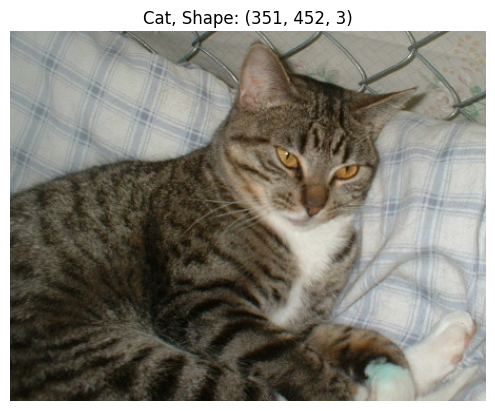

In [5]:
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
image_path_list = list(data_path.glob("*/*/*.jpg"))

random_image_path = random.choice(image_path_list)

image_class = random_image_path.parent.stem

img = Image.open(random_image_path)
img_is_array = np.asarray(img)

plt.imshow(img)
plt.axis(False)
plt.title(f"{image_class}, Shape: {img_is_array.shape}")

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [7]:
data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

test_data_transform = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

In [8]:
transformed_image = data_transform(img)
transformed_image

tensor([[[0.6314, 0.6353, 0.6314,  ..., 0.6118, 0.5882, 0.5490],
         [0.6353, 0.6431, 0.6392,  ..., 0.6078, 0.5882, 0.5373],
         [0.6431, 0.6392, 0.6431,  ..., 0.5922, 0.5686, 0.5569],
         ...,
         [0.6431, 0.5961, 0.5922,  ..., 0.1098, 0.1098, 0.1490],
         [0.6980, 0.6392, 0.5922,  ..., 0.0784, 0.0706, 0.1059],
         [0.7647, 0.6745, 0.6235,  ..., 0.1216, 0.1137, 0.1059]],

        [[0.6314, 0.6275, 0.6196,  ..., 0.6314, 0.6078, 0.5725],
         [0.6314, 0.6275, 0.6157,  ..., 0.6235, 0.6118, 0.5725],
         [0.6314, 0.6157, 0.6275,  ..., 0.6157, 0.5961, 0.5882],
         ...,
         [0.6627, 0.6196, 0.5882,  ..., 0.1059, 0.1020, 0.1451],
         [0.7137, 0.6588, 0.6118,  ..., 0.0745, 0.0667, 0.1020],
         [0.7725, 0.6824, 0.6431,  ..., 0.1137, 0.1059, 0.1059]],

        [[0.5843, 0.5843, 0.5647,  ..., 0.6118, 0.5961, 0.5765],
         [0.5804, 0.5725, 0.5529,  ..., 0.6078, 0.6039, 0.5804],
         [0.5804, 0.5569, 0.5765,  ..., 0.6078, 0.6000, 0.

Text(0.5, 1.0, 'Cat, Shape: torch.Size([3, 64, 64])')

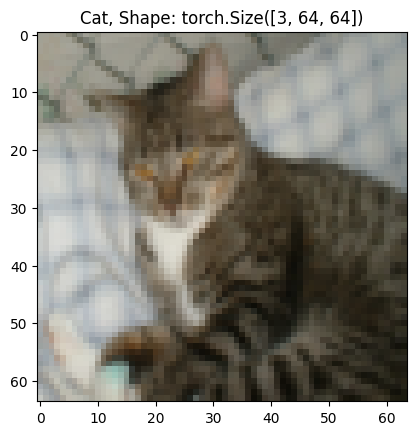

In [9]:
plt.imshow(transformed_image.permute(1, 2, 0))
plt.title(f"{image_class}, Shape: {transformed_image.shape}")

# Loading data using 'ImageFolder'

In [10]:
train_data = datasets.ImageFolder(root=train_path,
                                  transform=data_transform)

test_data = datasets.ImageFolder(root=test_path,
                                 transform=test_data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 5647
     Root location: data\train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 1352
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [11]:
# Get class names as list
class_names = train_data.classes
class_names

['Cat', 'Dog']

In [12]:
# Get class names as dictionary 
class_dict = train_data.class_to_idx
class_dict

{'Cat': 0, 'Dog': 1}

In [13]:
len(train_data), len(test_data)

(5647, 1352)

# Turn loaded images into 'DataLoader'

In [14]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              num_workers=NUM_WORKERS,
                              shuffle=True)

test_dataloader = DataLoader(dataset=test_data,
                             batch_size=BATCH_SIZE,
                             num_workers=NUM_WORKERS,
                             shuffle=False)

train_dataloader, test_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x27247ce4ac0>,
 <torch.utils.data.dataloader.DataLoader at 0x27247ce4250>)

In [15]:
img_custom, label_custom = next(iter(train_dataloader))

img_custom.shape, label_custom.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [16]:
class DogVsCat(nn.Module):
    def __init__(self, input_shape, hidden_layers, output_shape):
        super().__init__()

        self.conv_block_layer_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_layers,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers,
                      out_channels=hidden_layers * 2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.conv_block_layer_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_layers*2,
                      out_channels=hidden_layers*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2),
            nn.ReLU(),
            #nn.Dropout(p=0.2),
            nn.Conv2d(in_channels=hidden_layers*2*2,
                      out_channels=hidden_layers*2*2*2,
                      kernel_size=3,
                      padding=1,
                      stride=1),
            nn.BatchNorm2d(num_features=hidden_layers*2*2*2),
            nn.ReLU(),
           # nn.Dropout(p=0.2),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classification = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_layers*16*16*8,
                      #out_features=output_shape
                      out_features=128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, output_shape)
        )

    def forward(self, x):
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_1(x)
        #print(f"Shape: {x.shape}")
        x = self.conv_block_layer_2(x)
        #print(f"Shape: {x.shape}")
        x = self.classification(x)
        #print(f"Shape: {x.shape}")
        return x
        

In [17]:
model_0 = DogVsCat(input_shape=3, hidden_layers=16, output_shape=1).to(device)
model_0

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): S

In [18]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [19]:
# Check the correct shape on dummy tensor
dummy_input = torch.randn(32, 3, 64, 64)
output = model_0(dummy_input.to(device))
output

tensor([[ 0.0623],
        [ 0.7524],
        [ 0.2542],
        [ 0.1879],
        [-0.2820],
        [-0.2970],
        [ 0.3606],
        [ 0.5042],
        [ 0.1603],
        [ 0.5638],
        [-0.5515],
        [ 0.4616],
        [ 0.3272],
        [ 0.3856],
        [ 1.3703],
        [ 0.5102],
        [ 0.2488],
        [ 0.5742],
        [ 0.3132],
        [ 0.4051],
        [ 0.2578],
        [ 0.3905],
        [ 0.9354],
        [ 0.3906],
        [ 0.5137],
        [ 0.0685],
        [ 0.4469],
        [ 0.4471],
        [ 0.4572],
        [ 0.6092],
        [-0.1548],
        [ 0.6560]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [20]:
from tqdm import tqdm
import time

In [21]:
epochs = 1

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    model_0.train()
    train_loss, train_acc = 0, 0
    
    for batch, (X, y) in enumerate(train_dataloader):
        X, y = X.to(device), y.to(device)

        y = y.unsqueeze(dim=1).float()
        
        y_pred = model_0(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()

        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        train_acc += (y_pred_class==y).sum().item() / len(y_pred)

    train_loss /= len(train_dataloader)
    train_acc = (train_acc / len(train_dataloader)) * 100
    
    model_0.eval()
    test_loss, test_acc = 0, 0
    
    with torch.inference_mode():
        for batch, (X, y) in enumerate(test_dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model_0(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            test_acc += (test_pred_class==y).sum().item() / len(test_pred)
    
        test_loss /= len(test_dataloader)
        test_acc = (test_acc / len(test_dataloader)) * 100

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss}, Test Accuracy: {test_acc}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  0%|          | 0/1 [00:00<?, ?it/s]C:\Users\piotr\anaconda3\envs\test\lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 1/1 [00:18<00:00, 18.53s/it]

Epoch: 0 | Train Loss: 0.8847, Train Accuracy: 55.96 | Test Loss: 0.6547641629396483, Test Accuracy: 63.29941860465116
Total time: 18.535386323928833


# Plot model_0 results

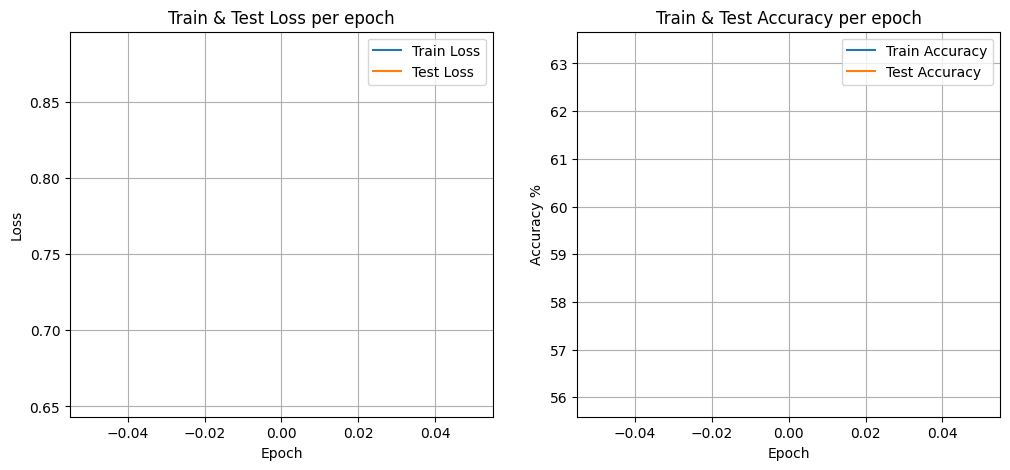

In [22]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()



In [23]:
print(len(results["train_loss"]), len(results["test_loss"]))
print(len(results["train_acc"]), len(results["test_acc"]))

1 1
1 1


In [24]:
# Build train and test function to make training easier
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim,
               device=device):

    train_loss, correct_preds, total_samples = 0, 0, 0
    model.train()

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        y = y.unsqueeze(dim=1).float()
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss.item()
        
        optimizer.zero_grad()

        loss.backward()

        optimizer.step()
        
        y_pred_class = (torch.sigmoid(y_pred) > 0.5).float()
        #train_acc += (y_pred_class==y).sum().item() / len(y_pred)
        correct_preds += (y_pred_class == y).sum().item()
        total_samples += y.size(0)

    train_loss /= len(dataloader)
    #train_acc = (train_acc / len(dataloader)) * 100
    train_acc = (correct_preds / total_samples) * 100
    
    return train_loss, train_acc

In [25]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):

    test_loss, correct_preds, total_samples = 0, 0, 0
    model.eval()
    with torch.inference_mode():
        for batch, (X, y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)

            y = y.unsqueeze(dim=1).float()
        
            test_pred = model(X)

            loss = loss_fn(test_pred, y)
            test_loss += loss.item()

            test_pred_class = (torch.sigmoid(test_pred) > 0.5).float()
            #test_acc += (test_pred_class==y).sum().item() / len(test_pred)
            correct_preds += (test_pred_class == y).sum().item()
            total_samples += y.size(0)
    
    test_loss /= len(dataloader)
    #test_acc = (test_acc / len(dataloader)) * 100
    test_acc = (correct_preds / total_samples) * 100
    return test_loss, test_acc

# Augmentation data

In [26]:
train_data_transform_augmentation = transforms.Compose([
    #transforms.Resize(size=(64, 64)),
    transforms.RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=25),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.05),
    #transforms.RandomAffine(degrees=15, translate=(1, 1)),
    #transforms.TrivialAugmentWide(num_magnitude_bins=31), # used to differentiate the data
    transforms.GaussianBlur(kernel_size=3),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])

test_data = transforms.Compose([
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])
train_data_transform_augmentation, test_data

(Compose(
     RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
     RandomHorizontalFlip(p=0.5)
     RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
     ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
     GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ),
 Compose(
     Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
     ToTensor()
     Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
 ))

In [27]:
train_data_augmentation = datasets.ImageFolder(root=train_path,
                                               transform=train_data_transform_augmentation)
test_data_augmentation = datasets.ImageFolder(root=test_path,
                                              transform=test_data)

train_data_augmentation, test_data_augmentation

(Dataset ImageFolder
     Number of datapoints: 5647
     Root location: data\train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(64, 64), scale=(0.9, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
                RandomHorizontalFlip(p=0.5)
                RandomRotation(degrees=[-25.0, 25.0], interpolation=nearest, expand=False, fill=0)
                ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.05, 0.05))
                GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
            ),
 Dataset ImageFolder
     Number of datapoints: 1352
     Root location: data\test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5

In [28]:
BATCH_SIZE = 32
NUM_WORKERS = 0

train_dataloader_augmentation = DataLoader(dataset=train_data_augmentation,
                                           batch_size=BATCH_SIZE,
                                           num_workers=NUM_WORKERS,
                                           shuffle=True)

test_dataloader_augmentation = DataLoader(dataset=test_data_augmentation,
                                          batch_size=BATCH_SIZE,
                                          num_workers=NUM_WORKERS,
                                          shuffle=False)

train_dataloader_augmentation, test_dataloader_augmentation

(<torch.utils.data.dataloader.DataLoader at 0x272439f11f0>,
 <torch.utils.data.dataloader.DataLoader at 0x2723b562b20>)

In [29]:
len(class_names)

2

In [30]:
model_1 = DogVsCat(input_shape=3, hidden_layers=8, output_shape=1).to(device)
model_1

DogVsCat(
  (conv_block_layer_1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_layer_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification): Sequen

In [31]:
# Setup loss function and optimizer
loss_fn = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)
                             #lr=0.00025)
#optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01, momentum=0.9)
loss_fn, optimizer

(BCEWithLogitsLoss(),
 Adam (
 Parameter Group 0
     amsgrad: False
     betas: (0.9, 0.999)
     capturable: False
     differentiable: False
     eps: 1e-08
     foreach: None
     fused: None
     lr: 0.001
     maximize: False
     weight_decay: 0
 ))

In [32]:
# Train model_1 on augmentation data
epochs = 50

start_time = time.time()

results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []}

for epoch in tqdm(range(epochs)):

    train_loss, train_acc = train_step(model=model_1,
               dataloader=train_dataloader_augmentation,
               loss_fn=loss_fn,
               optimizer=optimizer)

    test_loss, test_acc = test_step(model=model_1,
              dataloader=test_dataloader_augmentation,
              loss_fn=loss_fn)

    print(f"Epoch: {epoch} | Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.2f} | Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)
    


end_time = time.time()
train_time = end_time - start_time

print(f"Total time: {train_time}")

  2%|▏         | 1/50 [00:26<21:28, 26.30s/it]

Epoch: 0 | Train Loss: 0.7578, Train Accuracy: 55.20 | Test Loss: 0.6522, Test Accuracy: 63.24


  4%|▍         | 2/50 [00:55<22:16, 27.85s/it]

Epoch: 1 | Train Loss: 0.6685, Train Accuracy: 58.83 | Test Loss: 0.6088, Test Accuracy: 69.08


  6%|▌         | 3/50 [01:25<22:35, 28.84s/it]

Epoch: 2 | Train Loss: 0.6483, Train Accuracy: 62.14 | Test Loss: 0.6251, Test Accuracy: 67.31


  8%|▊         | 4/50 [01:53<21:54, 28.59s/it]

Epoch: 3 | Train Loss: 0.6399, Train Accuracy: 61.71 | Test Loss: 0.6042, Test Accuracy: 66.86


 10%|█         | 5/50 [02:23<21:46, 29.03s/it]

Epoch: 4 | Train Loss: 0.6289, Train Accuracy: 64.67 | Test Loss: 0.5461, Test Accuracy: 71.82


 12%|█▏        | 6/50 [02:48<20:23, 27.81s/it]

Epoch: 5 | Train Loss: 0.6105, Train Accuracy: 66.07 | Test Loss: 0.5771, Test Accuracy: 71.75


 14%|█▍        | 7/50 [03:14<19:33, 27.30s/it]

Epoch: 6 | Train Loss: 0.6225, Train Accuracy: 64.69 | Test Loss: 0.5603, Test Accuracy: 71.75


 16%|█▌        | 8/50 [03:45<19:51, 28.36s/it]

Epoch: 7 | Train Loss: 0.5984, Train Accuracy: 68.12 | Test Loss: 0.5468, Test Accuracy: 73.30


 18%|█▊        | 9/50 [04:15<19:40, 28.79s/it]

Epoch: 8 | Train Loss: 0.6002, Train Accuracy: 67.56 | Test Loss: 0.5314, Test Accuracy: 73.08


 20%|██        | 10/50 [04:40<18:31, 27.79s/it]

Epoch: 9 | Train Loss: 0.5856, Train Accuracy: 68.55 | Test Loss: 0.5497, Test Accuracy: 72.86


 22%|██▏       | 11/50 [05:07<17:52, 27.50s/it]

Epoch: 10 | Train Loss: 0.5894, Train Accuracy: 68.83 | Test Loss: 0.5658, Test Accuracy: 73.52


 24%|██▍       | 12/50 [05:34<17:17, 27.30s/it]

Epoch: 11 | Train Loss: 0.5856, Train Accuracy: 68.51 | Test Loss: 0.5322, Test Accuracy: 74.41


 26%|██▌       | 13/50 [06:02<16:56, 27.47s/it]

Epoch: 12 | Train Loss: 0.5743, Train Accuracy: 69.91 | Test Loss: 0.5280, Test Accuracy: 74.33


 28%|██▊       | 14/50 [06:34<17:23, 28.98s/it]

Epoch: 13 | Train Loss: 0.5663, Train Accuracy: 70.44 | Test Loss: 0.5348, Test Accuracy: 74.56


 30%|███       | 15/50 [07:05<17:07, 29.36s/it]

Epoch: 14 | Train Loss: 0.5772, Train Accuracy: 70.14 | Test Loss: 0.5408, Test Accuracy: 73.52


 32%|███▏      | 16/50 [07:36<16:54, 29.85s/it]

Epoch: 15 | Train Loss: 0.5641, Train Accuracy: 70.82 | Test Loss: 0.5243, Test Accuracy: 76.11


 34%|███▍      | 17/50 [08:05<16:18, 29.64s/it]

Epoch: 16 | Train Loss: 0.5563, Train Accuracy: 71.67 | Test Loss: 0.5525, Test Accuracy: 73.52


 36%|███▌      | 18/50 [08:32<15:26, 28.96s/it]

Epoch: 17 | Train Loss: 0.5504, Train Accuracy: 70.66 | Test Loss: 0.5001, Test Accuracy: 77.14


 38%|███▊      | 19/50 [09:02<15:09, 29.34s/it]

Epoch: 18 | Train Loss: 0.5578, Train Accuracy: 71.29 | Test Loss: 0.5172, Test Accuracy: 77.14


 40%|████      | 20/50 [09:28<14:09, 28.33s/it]

Epoch: 19 | Train Loss: 0.5410, Train Accuracy: 71.70 | Test Loss: 0.4949, Test Accuracy: 77.07


 42%|████▏     | 21/50 [09:58<13:55, 28.80s/it]

Epoch: 20 | Train Loss: 0.5425, Train Accuracy: 71.52 | Test Loss: 0.5210, Test Accuracy: 76.33


 44%|████▍     | 22/50 [10:30<13:51, 29.70s/it]

Epoch: 21 | Train Loss: 0.5423, Train Accuracy: 72.60 | Test Loss: 0.5169, Test Accuracy: 76.85


 46%|████▌     | 23/50 [11:06<14:12, 31.58s/it]

Epoch: 22 | Train Loss: 0.5305, Train Accuracy: 73.58 | Test Loss: 0.5522, Test Accuracy: 73.22


 48%|████▊     | 24/50 [11:39<13:52, 32.00s/it]

Epoch: 23 | Train Loss: 0.5341, Train Accuracy: 72.50 | Test Loss: 0.5260, Test Accuracy: 75.37


 50%|█████     | 25/50 [12:13<13:38, 32.75s/it]

Epoch: 24 | Train Loss: 0.5358, Train Accuracy: 72.84 | Test Loss: 0.4916, Test Accuracy: 76.85


 52%|█████▏    | 26/50 [12:43<12:42, 31.76s/it]

Epoch: 25 | Train Loss: 0.5234, Train Accuracy: 74.73 | Test Loss: 0.4948, Test Accuracy: 78.11


 54%|█████▍    | 27/50 [13:14<12:02, 31.43s/it]

Epoch: 26 | Train Loss: 0.5264, Train Accuracy: 74.25 | Test Loss: 0.5147, Test Accuracy: 76.70


 56%|█████▌    | 28/50 [13:46<11:40, 31.84s/it]

Epoch: 27 | Train Loss: 0.5077, Train Accuracy: 74.91 | Test Loss: 0.5246, Test Accuracy: 76.41


 58%|█████▊    | 29/50 [14:19<11:11, 31.97s/it]

Epoch: 28 | Train Loss: 0.5103, Train Accuracy: 74.68 | Test Loss: 0.5628, Test Accuracy: 74.48


 60%|██████    | 30/50 [14:52<10:49, 32.47s/it]

Epoch: 29 | Train Loss: 0.5126, Train Accuracy: 75.37 | Test Loss: 0.4865, Test Accuracy: 78.25


 62%|██████▏   | 31/50 [15:23<10:06, 31.90s/it]

Epoch: 30 | Train Loss: 0.5059, Train Accuracy: 75.35 | Test Loss: 0.4891, Test Accuracy: 79.36


 64%|██████▍   | 32/50 [15:50<09:10, 30.60s/it]

Epoch: 31 | Train Loss: 0.5093, Train Accuracy: 74.73 | Test Loss: 0.4922, Test Accuracy: 77.74


 66%|██████▌   | 33/50 [16:19<08:29, 29.99s/it]

Epoch: 32 | Train Loss: 0.4932, Train Accuracy: 75.63 | Test Loss: 0.5362, Test Accuracy: 74.11


 68%|██████▊   | 34/50 [16:48<07:53, 29.59s/it]

Epoch: 33 | Train Loss: 0.5047, Train Accuracy: 75.12 | Test Loss: 0.4621, Test Accuracy: 80.10


 70%|███████   | 35/50 [17:14<07:09, 28.62s/it]

Epoch: 34 | Train Loss: 0.4997, Train Accuracy: 75.44 | Test Loss: 0.4727, Test Accuracy: 79.36


 72%|███████▏  | 36/50 [17:42<06:37, 28.42s/it]

Epoch: 35 | Train Loss: 0.4873, Train Accuracy: 75.49 | Test Loss: 0.4772, Test Accuracy: 80.03


 74%|███████▍  | 37/50 [18:12<06:14, 28.83s/it]

Epoch: 36 | Train Loss: 0.4914, Train Accuracy: 76.47 | Test Loss: 0.4541, Test Accuracy: 81.07


 76%|███████▌  | 38/50 [18:41<05:47, 28.96s/it]

Epoch: 37 | Train Loss: 0.4896, Train Accuracy: 75.19 | Test Loss: 0.4704, Test Accuracy: 79.51


 78%|███████▊  | 39/50 [19:12<05:26, 29.66s/it]

Epoch: 38 | Train Loss: 0.4786, Train Accuracy: 75.92 | Test Loss: 0.4469, Test Accuracy: 80.25


 80%|████████  | 40/50 [19:39<04:47, 28.71s/it]

Epoch: 39 | Train Loss: 0.4893, Train Accuracy: 76.15 | Test Loss: 0.4726, Test Accuracy: 79.51


 82%|████████▏ | 41/50 [20:06<04:15, 28.39s/it]

Epoch: 40 | Train Loss: 0.4712, Train Accuracy: 77.32 | Test Loss: 0.4442, Test Accuracy: 79.81


 84%|████████▍ | 42/50 [20:39<03:57, 29.68s/it]

Epoch: 41 | Train Loss: 0.4762, Train Accuracy: 76.98 | Test Loss: 0.4393, Test Accuracy: 80.70


 86%|████████▌ | 43/50 [21:12<03:34, 30.64s/it]

Epoch: 42 | Train Loss: 0.4639, Train Accuracy: 77.94 | Test Loss: 0.4370, Test Accuracy: 80.99


 88%|████████▊ | 44/50 [21:45<03:07, 31.25s/it]

Epoch: 43 | Train Loss: 0.4657, Train Accuracy: 77.05 | Test Loss: 0.4280, Test Accuracy: 81.29


 90%|█████████ | 45/50 [22:16<02:35, 31.16s/it]

Epoch: 44 | Train Loss: 0.4697, Train Accuracy: 78.24 | Test Loss: 0.4297, Test Accuracy: 81.66


 92%|█████████▏| 46/50 [22:41<01:58, 29.51s/it]

Epoch: 45 | Train Loss: 0.4602, Train Accuracy: 77.65 | Test Loss: 0.4390, Test Accuracy: 81.21


 94%|█████████▍| 47/50 [23:12<01:29, 29.94s/it]

Epoch: 46 | Train Loss: 0.4694, Train Accuracy: 77.12 | Test Loss: 0.4560, Test Accuracy: 80.92


 96%|█████████▌| 48/50 [23:50<01:04, 32.43s/it]

Epoch: 47 | Train Loss: 0.4429, Train Accuracy: 78.94 | Test Loss: 0.4177, Test Accuracy: 81.73


 98%|█████████▊| 49/50 [24:21<00:31, 31.95s/it]

Epoch: 48 | Train Loss: 0.4514, Train Accuracy: 78.20 | Test Loss: 0.4848, Test Accuracy: 77.66


100%|██████████| 50/50 [24:52<00:00, 29.86s/it]

Epoch: 49 | Train Loss: 0.4516, Train Accuracy: 78.09 | Test Loss: 0.4129, Test Accuracy: 81.95
Total time: 1492.8218202590942


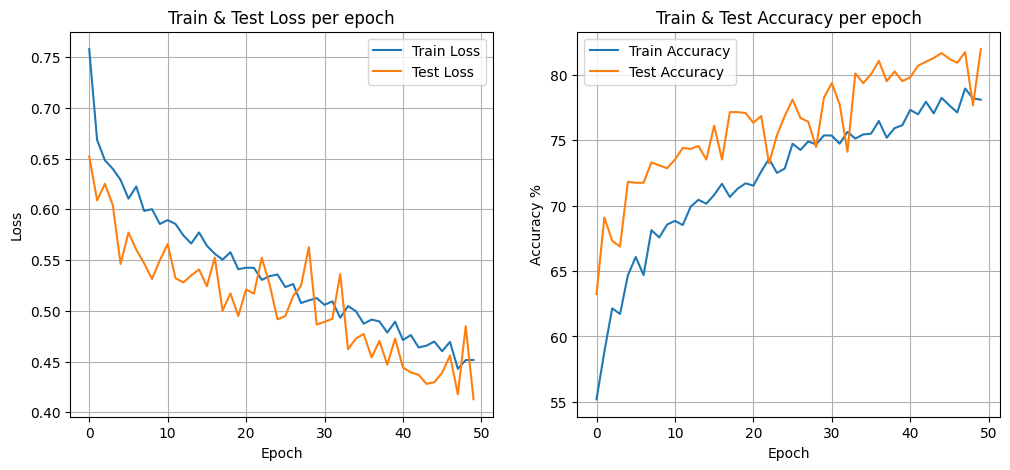

In [33]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(epochs), results["train_loss"], label="Train Loss")
plt.plot(range(epochs), results["test_loss"], label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train & Test Loss per epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(range(epochs), results["train_acc"], label="Train Accuracy")
plt.plot(range(epochs), results["test_acc"], label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy %")
plt.title("Train & Test Accuracy per epoch")
plt.legend()
plt.grid()

In [34]:
from torch.utils.data import Subset

In [35]:
train_100_images = Subset(train_data_augmentation, range(100))
test_20_images = Subset(test_data_augmentation, range(20))

len(train_100_images), len(test_20_images)

(100, 20)